# Test of class Hamiltonian_QED



This notebook uses the class in 'Hamiltonian_QED_oprt.py' and 'Hamiltonian_QED_sym.py' that builds the Hamiltonian in terms of Pauli matrices.


In [34]:
import qiskit

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations

In [37]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import *
import primme

##### Puregauge circuit

In [38]:
#class input parameters:
n_sites = [3,2]#how many sites for every dimension
g=0.5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = True
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign
sparse_pauli=False
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 3

In [39]:
latt = HCLattice(n_sites,pbc=pbc)


In [40]:
# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': None,
    'e_op_out_plus': e_op_out_plus
}
hamilt_sym = HamiltonianQED_sym(config,display_hamiltonian=False)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.005446195602416992 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 0.7211260795593262 seconds
>> Suppression term built.  Execution time: 0.0007307529449462891 seconds


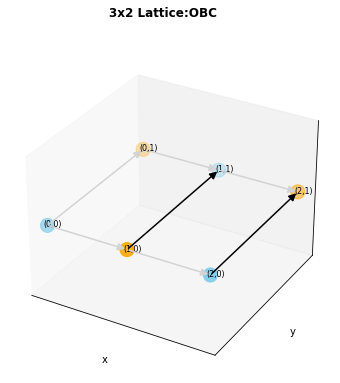

In [41]:
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free)#,savefig_dir='.')

In [42]:
Hamiltonian_Pauli_tot_vqe = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0)


In [43]:
nlayers= 1
entanglement='full'#triangular,linear,full
rzlayer=False
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f)

[0, 2]
Total n.er of CNOT gates (Toffoli are decomposed): 32
Total n.er of parameters: 8


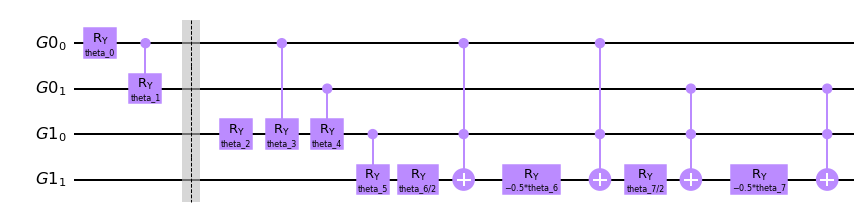

In [44]:

qc_tot2,first_layer_par,th_gauge= ansatz_class.puregauge_circuit_entang(entanglement=entanglement,rzlayer=rzlayer,nlayers=nlayers)
print(first_layer_par)
print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose().count_ops())['cx'])
print('Total n.er of parameters:',qc_tot2.num_parameters)
#print(ansatz_class.first_layer_par)
#parameter counts
#ansatz_class.parameters_count(n_qubits,ngauge)
qc_tot2.draw('mpl',fold=-1,style='clifford')


##### Composite circuit: gauge + fermions

In [45]:
#class input parameters:
n_sites = [2,2]#how many sites for every dimension
g=0.5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = False
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign
sparse_pauli=False
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 3

In [46]:
latt = HCLattice(n_sites,pbc=pbc)


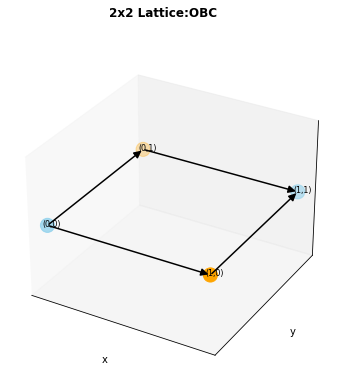

In [47]:

latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)


In [48]:
#latt.func_qstatic_dist()#ch_val=1)
#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st ) for st in latt.distances_coord]#,savefig_dir='.')

In [49]:
# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': None,
    'e_op_out_plus': e_op_out_plus
}
hamilt_sym = HamiltonianQED_sym(config,display_hamiltonian=False)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.011922836303710938 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 2.173311948776245 seconds
>> Suppression term built.  Execution time: 0.002981901168823242 seconds


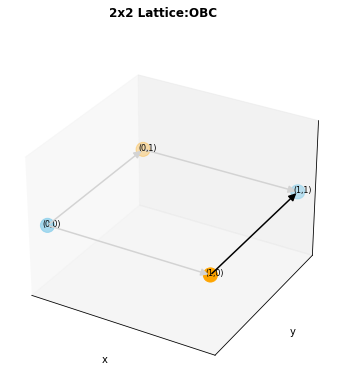

In [50]:
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free)#,savefig_dir='.')

In [51]:
Hamiltonian_Pauli_tot_vqe = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0)


[0]
Total n.er of CNOT gates (Toffoli are decomposed): 56
Total n.er of parameters: 8


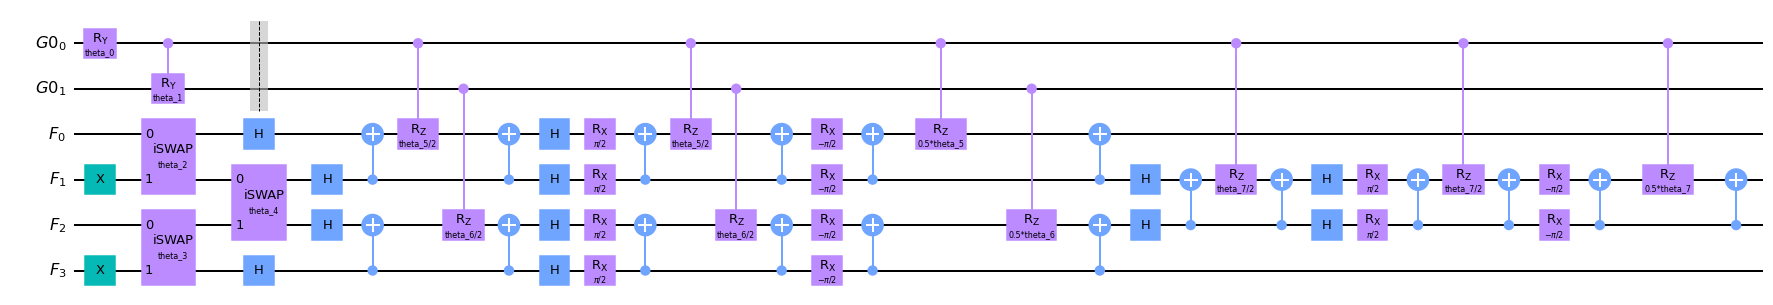

In [54]:
nlayers= 1
entanglement='full'#triangular,linear,full
rzlayer=False
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))


ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f)
qc_tot2,first_layer_par = ansatz_class.gauge_fermion_circuit(entanglement=entanglement,rzlayer=rzlayer,nlayers=nlayers)
print(first_layer_par)
print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose().count_ops())['cx'])
print('Total n.er of parameters:',qc_tot2.num_parameters)
#print(ansatz_class.first_layer_par)
#parameter counts
#ansatz_class.parameters_count(n_qubits,ngauge)
qc_tot2.draw('mpl',fold=-1,style='clifford')#,style='bw')

In [53]:
qc_tot2.depth()

29